In [20]:
%load_ext autoreload
%autoreload 2
import torch
import copy
import numpy as np
import matplotlib.pyplot as plt

from src.models.training.train import TrainModule
from src.loop_calling.dataset.loop_dataset import LoopDataset
from src.utils import predict_matrix, plot_and_save_matrices, load_bigwig_signal
from src.ledidi.edit_tasks import evaluate_asym_to_sym
from src.ledidi.utils import report_nt_changes
from src.ledidi.utils import plot_multi_site_attributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in model and dataset

In [4]:
%%capture
CKPT="./data/chiron-model.ckpt"
model = TrainModule.load_from_checkpoint(CKPT)
model.eval()
model.to("cuda")

In [5]:
dataset = LoopDataset(
        regions_file_path="./data/extruding_loops.csv",
        cool_file_path="./data/A673_WT_CTCF_5000.cool",
        fasta_dir="./data/chromosomes",
        genomic_feature_path=None,
        mode="test",
        val_chroms=[],
        test_chroms=["chr2", "chr6", "chr19"],
        use_pretrained_backbone=True
    )

In [45]:
elem = dataset[646]
pred = predict_matrix(elem, model, 'cuda')

In [12]:
elem["idx"] = 646

### Run edit framework, depending on chosen threshold, more or fewer edits get selected

In [8]:
from src.ledidi.ledidi_create_stripe import evaluate_element

In [13]:
evaluate_element(elem, model, threshold=10, device="cuda", stripe="X", run_dir="ex1")

Threshold: 41.56707000732422
iter=I	input_loss=0.0	output_loss=1.042e+03	total_loss=1.042e+03	time=0.0
iter=100	input_loss=395.0	output_loss= 0.0	total_loss=31.6	time=42.15
iter=200	input_loss=163.0	output_loss= 0.0	total_loss=13.04	time=40.3
iter=300	input_loss=91.0	output_loss= 0.0	total_loss=7.28	time=40.42
iter=400	input_loss=62.0	output_loss= 0.0	total_loss=4.96	time=40.47
iter=500	input_loss=44.0	output_loss= 0.0	total_loss=3.52	time=40.53
iter=600	input_loss=21.0	output_loss= 0.0	total_loss=1.68	time=40.64
iter=700	input_loss=53.0	output_loss= 0.0	total_loss=4.24	time=40.46
iter=800	input_loss=18.0	output_loss= 0.0	total_loss=1.44	time=40.48
iter=900	input_loss=49.0	output_loss= 0.0	total_loss=3.92	time=40.5
iter=1000	input_loss=28.0	output_loss= 0.0	total_loss=2.24	time=40.55
iter=1100	input_loss=51.0	output_loss= 0.0	total_loss=4.08	time=40.45
iter=1200	input_loss=24.0	output_loss= 0.0	total_loss=1.92	time=40.5
iter=1300	input_loss= 7.0	output_loss=416.9	total_loss=417.5	time=

{'idx': 646,
 'loop_start': 43835000,
 'loop_end': 44275000,
 'stripe': 'X',
 'original_diff': 73.85304260253906,
 'edited_diff': 47.39983367919922,
 'mutations_raw': [481572],
 'mutations_final': [481572],
 'base_changes': ['G>C'],
 'single_edit_contrib': None,
 'chr': 'chr2',
 'contributions': [],
 'comment': 'Normal'}

### Investigate Edits

In [18]:
edited_sequence = torch.load("./ex1/chr2/best_onehot_646.pt")

In [23]:
deep_copy = copy.deepcopy(elem)
deep_copy['sequence'] = edited_sequence
pred_all = predict_matrix(deep_copy, model, 'cuda')

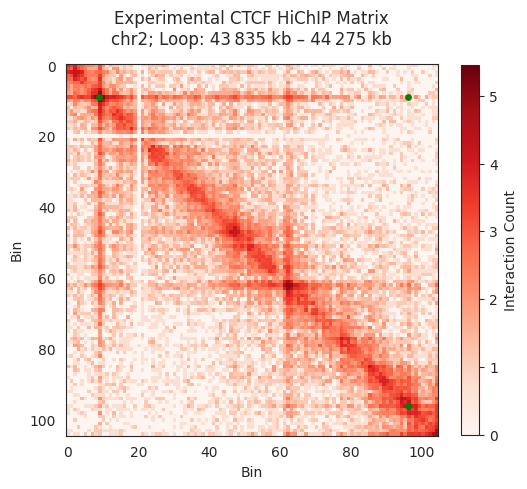

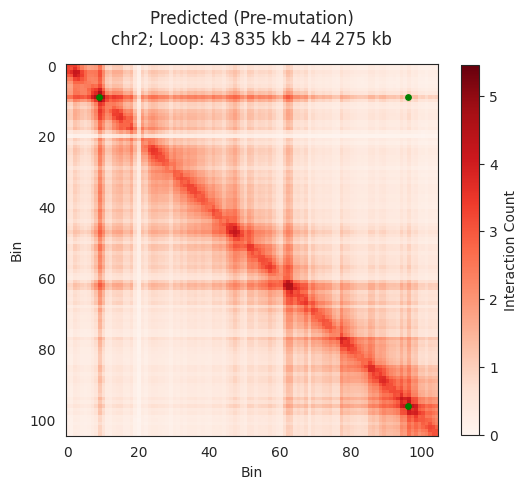

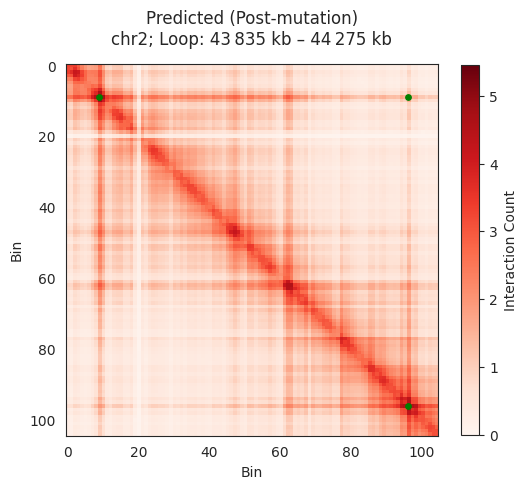

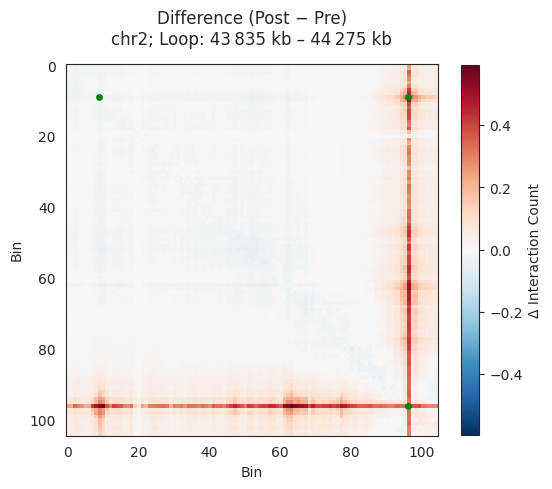

{'exp': '646/Asym_To_Sym_exp.svg',
 'pre': '646/Asym_To_Sym_pred_pre.svg',
 'post': '646/Asym_To_Sym_pred_post.svg',
 'diff': '646/Asym_To_Sym_diff.svg'}

In [28]:
%matplotlib inline
plot_and_save_matrices(elem, pred, pred_all, save_dir="646", prefix="Asym_To_Sym", show=True)

### Investigate Edit Location

In [29]:
from src.ledidi.utils import report_nt_changes
edits = report_nt_changes(elem["sequence"], deep_copy["sequence"])

Total sequence-positions with any mismatch: 1
481572: G → C


In [43]:
def plot_ctcf(elem, start, end, mark_start, mark_end):
    chrom = elem["chr"]
    signal = load_bigwig_signal("/cluster/work/boeva/shoenig/ews-ml/data/corigami/raw/A673_WT/genomic_features_data/CTCF/A673_WT_CTCF_coverage_FE.bw", chrom, start, end)
    x = np.arange(start, end)
    x = np.linspace(start, end, num=len(signal), endpoint=False)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, signal)
    ax.set_ylabel("Signal")
    ax.set_title("CTCF track")
    ax.set_xlim(start, end)
    
    if (mark_start is not None) and (mark_end is not None):
        hs, he = max(mark_start, start), min(mark_end, end)
        if hs < he:
            ax.axvspan(hs, he, alpha=0.2)
            ax.axvline(hs, linestyle="--", linewidth=0.8)
            ax.axvline(he, linestyle="--", linewidth=0.8)
    
    fig.tight_layout()

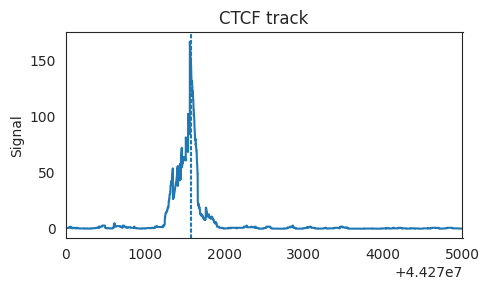

In [30]:
plot_ctcf(elem, elem["region_start"]+480000, elem["region_start"]+485000, elem["region_start"]+481572-1, elem["region_start"]+481572+1)

In [41]:
from src.ledidi.utils import plot_multi_site_attributions

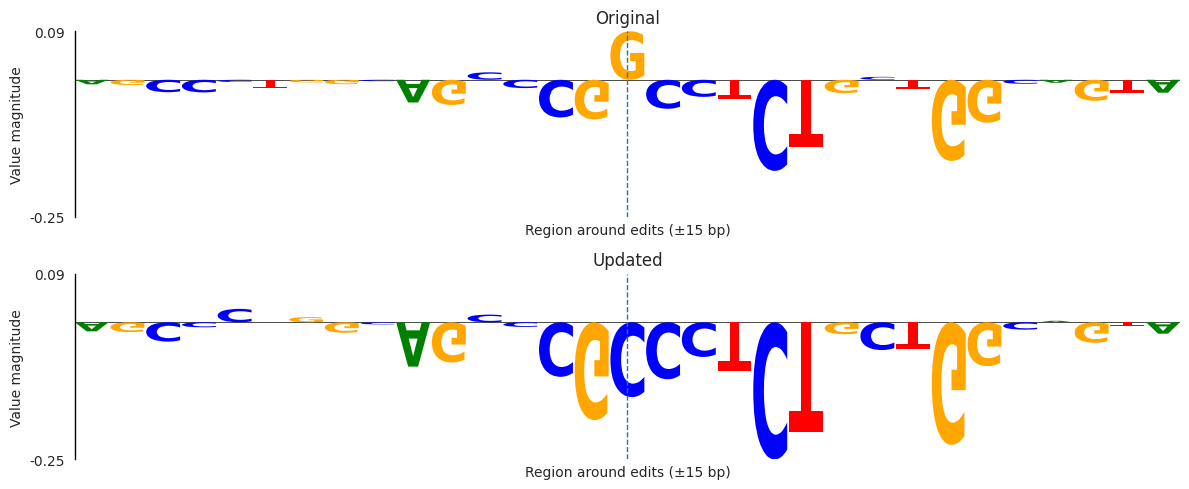

In [42]:
plot_multi_site_attributions(model, elem, edits, window_radius=15)